In [1]:
import torch
import triton
import triton.language as tl

/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


# code
- 一个比内置max还快的函数
- 真正行级别的算法，大家看完后，可以试试min函数怎么实现

In [6]:
class VALUES_INDICES:
    def __init__(self, values, indices):
        self.values = values
        self.indices = indices

@triton.jit
def _max_short(INPUT, VALUES, INDICES,
          stride0, stride1,
          M, N: tl.constexpr, 
          BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr):
    
    start_m = tl.program_id(0)
    input_offset = start_m * BLOCK_M * stride0
    input_ptrs = INPUT + input_offset +  tl.arange(0, BLOCK_M)[:, None] * stride0 + tl.arange(0, BLOCK_N)[None, :]
    mask_row = (start_m * BLOCK_M + tl.arange(0, BLOCK_M)[:, None]) < M
    mask_col = tl.arange(0, BLOCK_N) < N
    mask = mask_row & mask_col
    inp = tl.load(input_ptrs, mask=mask, other=float('-inf'))
    max_num, index = tl.max(inp, -1, return_indices=True)
    output_ptrs = VALUES + start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    tl.store(output_ptrs, max_num, mask=(start_m * BLOCK_M + tl.arange(0, BLOCK_M)) < M)
    indices_ptrs = INDICES + start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    tl.store(indices_ptrs, index, mask=(start_m * BLOCK_M + tl.arange(0, BLOCK_M)) < M)

@triton.jit
def _max_long(INPUT, VALUES, INDICES,
          stride0, stride1,
          M, N: tl.constexpr, 
          BLOCK_N: tl.constexpr):
    start_m = tl.program_id(0)
    base_ptrs = INPUT + start_m * stride0


    INPUT_ptrs = base_ptrs + tl.arange(0, BLOCK_N)
    mask = tl.arange(0, BLOCK_N) < N
    inp = tl.load(INPUT_ptrs, mask=mask)
    max_num, indices = tl.max(inp, 0, return_indices=True)  

    for start_n in range(BLOCK_N, N, BLOCK_N):
        INPUT_ptrs = base_ptrs + start_n  + tl.arange(0, BLOCK_N)
        mask = (start_n + tl.arange(0, BLOCK_N)) < N
        inp = tl.load(INPUT_ptrs, mask=mask)
        new_max_num, new_indices = tl.max(inp, 0, return_indices=True)  
        if new_max_num > max_num:
            max_num = new_max_num
            indices = start_n + new_indices

    tl.store(VALUES + start_m, max_num)
    tl.store(INDICES + start_m, indices)

def triton_max(tensor, axis=-1):
    # tensor = tensor.unsqueeze(-1)
    # if axis < 0:
    #     axis -= 1
    # tensor = tensor.transpose(axis, -1).squeeze(axis)
    tensor = torch.movedim(tensor, axis, -1)
    tensor_shape = tensor.shape
    tensor = tensor.reshape(-1, tensor_shape[-1])
    B,D = tensor.shape
    values = torch.empty(B, device=tensor.device, dtype=tensor.dtype)
    indices = torch.empty(B, device=tensor.device, dtype=torch.int64)
    if D <=256:
        tmp = triton.next_power_of_2(B)
        BLOCK_M= min(256, tmp)
        BLOCK_N=triton.next_power_of_2(D)
        grid = lambda meta: (triton.cdiv(B, meta['BLOCK_M']),)
        _max_short[grid](tensor, values, indices,
                tensor.stride(0),tensor.stride(1),
                    B,D,
                    BLOCK_M=BLOCK_M, BLOCK_N=BLOCK_N,
                    num_stages=4, num_warps=8
        )
    else:
        BLOCK_N = min(triton.next_power_of_2(D), 64*1024)
        _max_long[(B,)](tensor, values, indices, 
                tensor.stride(0),tensor.stride(1),
                    B,D,
                    BLOCK_N=BLOCK_N,
                    num_stages=4, num_warps=8
        )
    return VALUES_INDICES(values.reshape(*tensor_shape[:-1]),indices.reshape(*tensor_shape[:-1]))

In [7]:
x = torch.randn(64,64,64).cuda().to(torch.float16)
print(torch.allclose(triton_max(x, -1).values, x.max(-1).values))
print(torch.allclose(triton_max(x, -1).indices, x.max(-1).indices))
x = torch.randn(8,1, 64*1024).cuda().to(torch.float16)
print(torch.allclose(triton_max(x, -1).values, x.max(-1).values))
print(torch.allclose(triton_max(x, -1).indices, x.max(-1).indices))

True
True
True
True


# 大dim benchmark

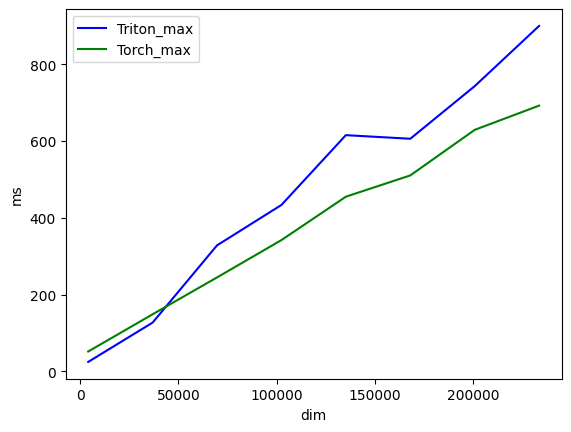

triton max:
        dim  Triton_max   Torch_max
0    4096.0   24.332035   51.494028
1   36864.0  126.835912  148.473531
2   69632.0  328.091681  244.561926
3  102400.0  433.436722  341.852814
4  135168.0  615.333974  454.926789
5  167936.0  605.923593  510.381341
6  200704.0  743.029594  629.116416
7  233472.0  900.008500  692.276657


In [4]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[4096 * i for i in range(1, 64+1, 8)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton_max",
            "Torch_max",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="triton max",  # name for the plot. Used also as a file name for saving the plot.
        args={'bs': 2046, 'axis': -1}
    ))
def benchmark(bs, dim, axis, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, dim).to(device).to(dtype)

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_max(tensor, axis))

    if provider == 'torch':
        # ms = triton.testing.do_bench(lambda: torch.max(tensor, 2))
        ms = triton.testing.do_bench(lambda: torch.max(tensor, axis))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


# 小dim benchmark

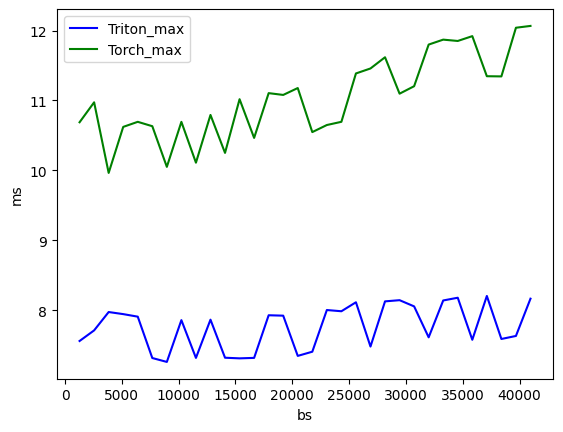

triton max:
         bs  Triton_max  Torch_max
0    1280.0    7.563159  10.688875
1    2560.0    7.714594  10.973956
2    3840.0    7.976942   9.965030
3    5120.0    7.947234  10.622697
4    6400.0    7.910816  10.695106
5    7680.0    7.319811  10.632568
6    8960.0    7.264045  10.051525
7   10240.0    7.861215  10.694627
8   11520.0    7.321494  10.111281
9   12800.0    7.867801  10.793393
10  14080.0    7.323989  10.251241
11  15360.0    7.315076  11.018380
12  16640.0    7.321770  10.465445
13  17920.0    7.930919  11.105134
14  19200.0    7.925185  11.079581
15  20480.0    7.350242  11.177849
16  21760.0    7.409972  10.548404
17  23040.0    8.005629  10.649500
18  24320.0    7.988177  10.695340
19  25600.0    8.116533  11.386380
20  26880.0    7.483763  11.457663
21  28160.0    8.129364  11.618019
22  29440.0    8.146361  11.097391
23  30720.0    8.057742  11.204062
24  32000.0    7.615379  11.799120
25  33280.0    8.142222  11.869691
26  34560.0    8.181362  11.850651
27  3584

In [5]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['bs'],  # argument names to use as an x-axis for the plot
        x_vals=[1280 * i for i in range(1, 32+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton_max",
            "Torch_max",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="triton max",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 4, 'axis': -1}
    ))
def benchmark(bs, dim, axis, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, dim).to(device).to(dtype)

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_max(tensor, axis))

    if provider == 'torch':
        # ms = triton.testing.do_bench(lambda: torch.max(tensor, 2))
        ms = triton.testing.do_bench(lambda: torch.max(tensor, axis))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


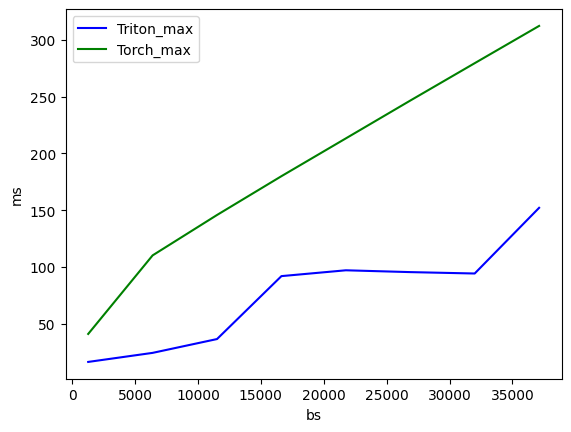

triton max:
        bs  Triton_max   Torch_max
0   1280.0   16.154224   40.834486
1   6400.0   24.137581  110.124141
2  11520.0   36.327973  145.761341
3  16640.0   91.840588  179.990873
4  21760.0   96.974500  213.319138
5  26880.0   95.367901  246.671915
6  32000.0   94.138935  279.642344
7  37120.0  152.073503  312.511355


In [9]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['bs'],  # argument names to use as an x-axis for the plot
        x_vals=[1280 * i for i in range(1, 32+1, 4)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton_max",
            "Torch_max",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="triton max",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 4096, 'axis': 0}
    ))
def benchmark(bs, dim, axis, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, dim).to(device).to(dtype)

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_max(tensor, axis))

    if provider == 'torch':
        # ms = triton.testing.do_bench(lambda: torch.max(tensor, 2))
        ms = triton.testing.do_bench(lambda: torch.max(tensor, axis))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)
